In [2]:
# Notebook 02
# Define momentum metrics (rolling / EWMA) and visualize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [26]:
data_path = "../data/raw/Wimbledon_featured_matches.csv"
df = pd.read_csv(data_path)

# 选定一场比赛（把这里换成你想看的 match_id）
match_id = "2023-wimbledon-1701"
df_match = df[df["match_id"] == match_id].copy()

# 按比赛顺序排序：盘 -> 局 -> 分
df_match = df_match.sort_values(
    by=["set_no", "game_no", "point_no"]
).reset_index(drop=True)

# point_result: player1赢=+1, player2赢=-1
df_match["point_result"] = np.where(df_match["point_victor"] == 1, 1, -1)

# 用于对照的累计分差
df_match["cumulative_score"] = df_match["point_result"].cumsum()

df_match.shape, df_match.head()


((334, 48),
               match_id         player1         player2 elapsed_time  set_no  game_no  point_no  p1_sets  p2_sets  \
 0  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:00       1        1         1        0        0   
 1  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:25       1        1         2        0        0   
 2  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:01:19       1        1         3        0        0   
 3  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:02:17       1        1         4        0        0   
 4  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:03:02       1        1         5        0        0   
 
    p1_games  p2_games p1_score p2_score  server  serve_no  point_victor  p1_points_won  p2_points_won  game_victor  \
 0         0         0        0        0       2         1             2              0              1            0   
 1         0         0        0       15      

In [4]:
window = 15  # 先选一个不大的窗口（之后可以调）
df_match["momentum_rm"] = (
    df_match["point_result"]
    .rolling(window=window, min_periods=1)
    .mean()
)

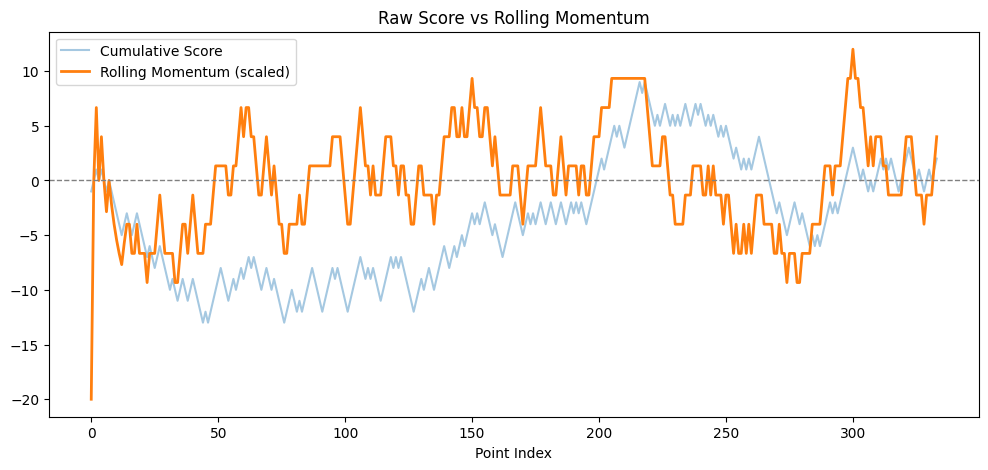

In [5]:
plt.figure(figsize=(12, 5))

plt.plot(df_match["cumulative_score"], label="Cumulative Score", alpha=0.4)
plt.plot(df_match["momentum_rm"] * 20, label="Rolling Momentum (scaled)", linewidth=2)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Raw Score vs Rolling Momentum")
plt.xlabel("Point Index")
plt.show()

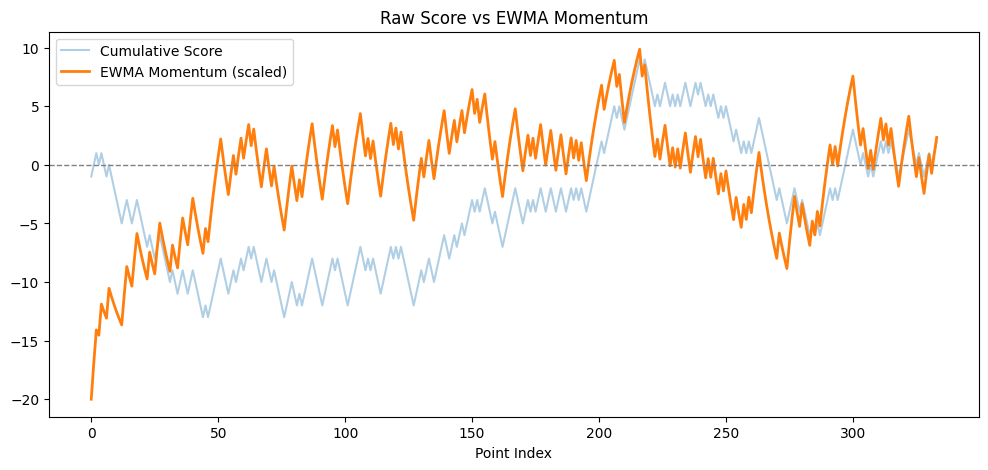

In [35]:
# EWMA momentum: 对最近得分更敏感
span = 25  # 类似“有效窗口”，可调参
df_match["momentum_ewm"] = df_match["point_result"].ewm(span=span, adjust=False).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_match["cumulative_score"], label="Cumulative Score", alpha=0.35)
plt.plot(df_match["momentum_ewm"] * 20, label="EWMA Momentum (scaled)", linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Raw Score vs EWMA Momentum")
plt.xlabel("Point Index")
plt.show()


In [36]:
# server 列：1 表示 player1 发球，2 表示 player2 发球（题目数据示例也是这么解释的）
# point_victor：1/2 表示该分 winner（题目示例解释一致）
# 先估计：发球方赢这一分的经验概率
server_wins = (df_match["point_victor"] == df_match["server"]).astype(int)
p_server_win = server_wins.mean()
p_server_win


np.float64(0.6107784431137725)

In [37]:
# 发球方是否赢分
server_wins = (df_match["point_victor"] == df_match["server"]).astype(int)

# 发球方赢分概率（经验估计）
p_server_win = server_wins.mean()

# 发球校正的单分贡献（先在发球方视角）
df_match["serve_adj"] = np.where(server_wins == 1, 1 - p_server_win, -p_server_win)

# 转到 Player1 视角（正=对P1有利）
df_match["serve_adj_p1"] = np.where(df_match["server"] == 1, df_match["serve_adj"], -df_match["serve_adj"])

# EWMA 平滑
span2 = 25
df_match["momentum_srv_ewm"] = df_match["serve_adj_p1"].ewm(span=span2, adjust=False).mean()

p_server_win, df_match[["server","point_victor","serve_adj_p1","momentum_srv_ewm"]].head()

(np.float64(0.6107784431137725),
    server  point_victor  serve_adj_p1  momentum_srv_ewm
 0       2             2     -0.389222         -0.389222
 1       2             1      0.610778         -0.312298
 2       2             1      0.610778         -0.241293
 3       2             2     -0.389222         -0.252672
 4       2             1      0.610778         -0.186252)

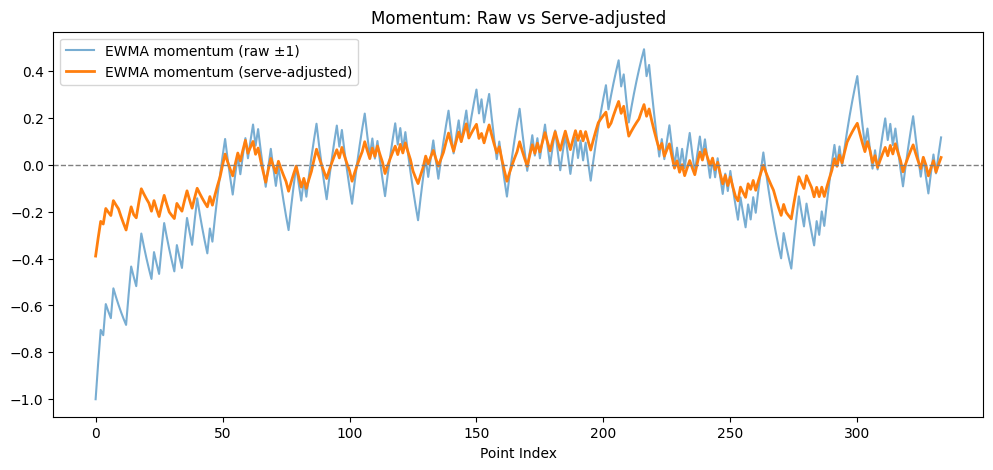

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(df_match["momentum_ewm"], label="EWMA momentum (raw ±1)", alpha=0.6)
plt.plot(df_match["momentum_srv_ewm"], label="EWMA momentum (serve-adjusted)", linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Momentum: Raw vs Serve-adjusted")
plt.xlabel("Point Index")
plt.show()

In [40]:
#计算swing points（局势转变点）
m = df_match["momentum_srv_ewm"]

trend = m.diff().ewm(span=5, adjust=False).mean()
amp_thr = m.abs().quantile(0.85)

rev = (
    (trend.shift(1) > 0) & (trend <= 0) |
    (trend.shift(1) < 0) & (trend >= 0)
)

df_match["swing_flag"] = (rev & (m.abs() > amp_thr)).astype(int)
idx = df_match.index[df_match["swing_flag"] == 1]

keep = []
i = 0
while i < len(idx):
    j = i
    group = [idx[i]]
    while j + 1 < len(idx) and idx[j+1] == idx[j] + 1:
        j += 1
        group.append(idx[j])
    # 在这个反转区间里，只留 |m| 最大的点
    best = max(group, key=lambda x: abs(m.loc[x]))
    keep.append(best)
    i = j + 1

df_match["swing_flag"] = 0
df_match.loc[keep, "swing_flag"] = 1





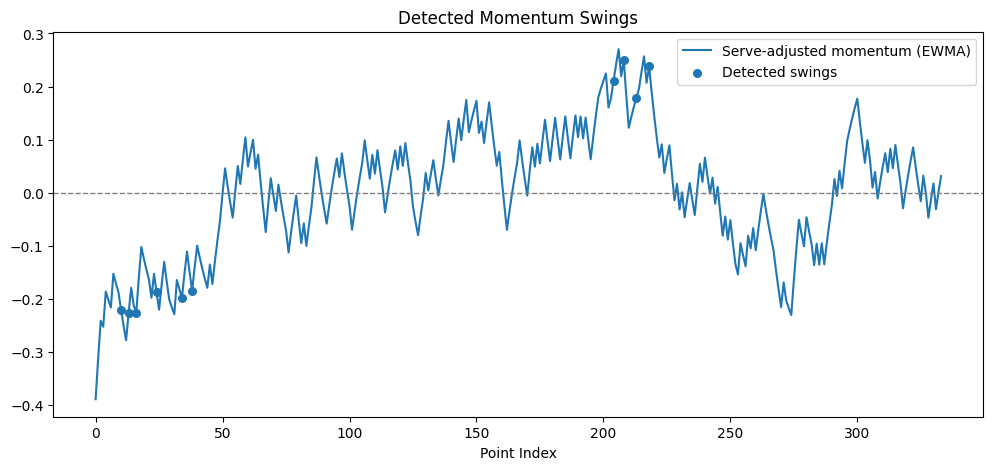

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(m, label="Serve-adjusted momentum (EWMA)")
swing_idx = df_match.index[df_match["swing_flag"]==1]
plt.scatter(swing_idx, m.loc[swing_idx], s=30, label="Detected swings")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Detected Momentum Swings")
plt.xlabel("Point Index")
plt.show()
